# 🧠 Projet Deep Learning : Reconnaissance Faciale avec MLP

## 🎯 Objectif
Concevoir un modèle de reconnaissance faciale à l'aide d’un **Perceptron Multicouche (MLP)** uniquement, sans CNN, en s’appuyant sur le prétraitement, la régularisation, l’augmentation de données et l’interprétation des résultats.

## 💡 Applications
- Systèmes de sécurité et contrôle d'accès
- Déverrouillage de téléphones
- Systèmes de surveillance intelligents
- Analyse biométrique

L’objectif est aussi de mieux maîtriser **PyTorch** et les bonnes pratiques de modélisation.

# Installation des bibliothèques nécessaires
Nous installons Optuna, une bibliothèque d'optimisation automatique d'hyperparamètres.

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 12.9 MB/s eta 0:00:00


#Configuration initiale et imports
Cette section contient tous les imports nécessaires pour notre projet : bibliothèques de traitement de données, visualisation, deep learning et optimisation. Nous configurons également le dispositif de calcul (GPU ou CPU).

In [ ]:
# ===== CELLULE 1 : Imports et configuration =====
# Imports de base pour l'analyse de données, visualisation et deep learning
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.datasets import fetch_lfw_people
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import optuna
from collections import Counter
import torchvision.transforms as transforms
from torch.utils.data import Dataset
import joblib

# Configuration du device (GPU si disponible, sinon CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("📌 Using device:", device)

📌 Using device: cuda


#Chargement et visualisation du dataset complet
Dans cette cellule, nous chargeons le dataset LFW (Labeled Faces in the Wild) complet avec un minimum de 10 visages par personne. Nous affichons ensuite un aperçu des données et la distribution des classes pour comprendre la répartition des visages par individu.


=== 📥 Chargement des images LFW (dataset complet) ===
Dataset complet - Images : (4324, 2914)
Dataset complet - Nombre de classes : 158


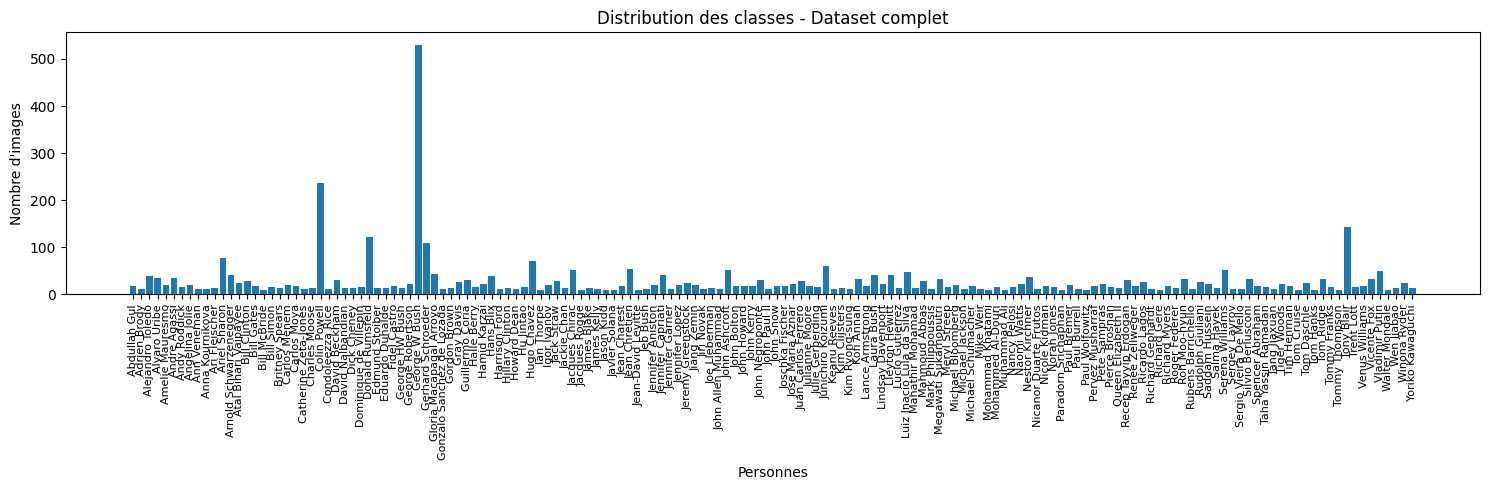

In [ ]:
# ===== CELLULE 3 : Chargement et visualisation des données complètes =====
# Chargement du dataset complet (min_faces_per_person=10)
# print("\n=== 📥 Chargement des images LFW (dataset complet) ===")
# lfw_all = fetch_lfw_people(min_faces_per_person=10, resize=0.5)  # images 62x47
print("\n=== 📥 Chargement des images LFW (dataset complet) ===")
lfw_all = fetch_lfw_people(min_faces_per_person=10, resize=0.5)  # images 62x47
X_all = lfw_all.data              # images aplaties (n_samples, 2914)
y_all = lfw_all.target            # étiquettes numériques
target_names_all = lfw_all.target_names
n_classes_all = len(target_names_all)

print(f"Dataset complet - Images : {X_all.shape}")
print(f"Dataset complet - Nombre de classes : {n_classes_all}")

# Visualisation de la distribution des classes (dataset complet)
unique, counts = np.unique(y_all, return_counts=True)
plt.figure(figsize=(15, 5))
plt.bar(target_names_all, counts)
plt.xticks(rotation=90, fontsize=8)
plt.title('Distribution des classes - Dataset complet')
plt.xlabel('Personnes')
plt.ylabel('Nombre d\'images')
plt.tight_layout()
plt.show()
# print("\n=== 📥 Chargement des images LFW (dataset complet) ===")

#Visualisation d'exemples de visages
Cette cellule affiche des exemples de visages du dataset pour mieux comprendre les données avec lesquelles nous travaillons. Un aperçu visuel est important pour évaluer la qualité et la variabilité des images.


=== ⚖️ Création d'un sous-ensemble équilibré ===

=== 📥 Chargement des images LFW (dataset équilibré) ===
Dataset équilibré - Images : (1140, 2914)
Dataset équilibré - Nombre de classes : 5


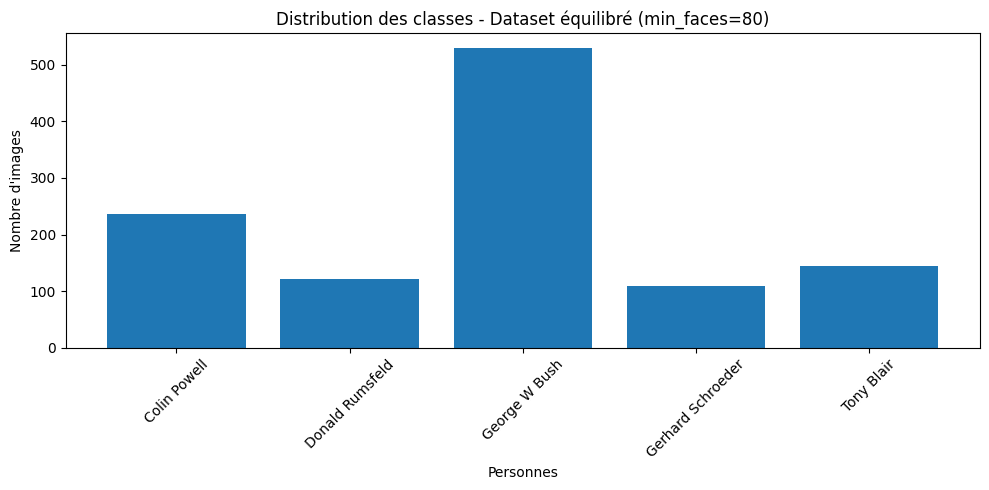

In [ ]:
# ===== CELLULE 4 : Création d'un sous-ensemble équilibré =====
# Sélection des personnes avec le plus grand nombre d'images (top 5)
print("\n=== ⚖️ Création d'un sous-ensemble équilibré ===")
print("\n=== 📥 Chargement des images LFW (dataset équilibré) ===")
lfw = fetch_lfw_people(min_faces_per_person=80, resize=0.5)  # images 62x47
X = lfw.data              # images aplaties (n_samples, 2914)
y = lfw.target            # étiquettes numériques
target_names = lfw.target_names
n_classes = len(target_names)

print(f"Dataset équilibré - Images : {X.shape}")
print(f"Dataset équilibré - Nombre de classes : {n_classes}")

# Distribution des classes dans le dataset équilibré
unique, counts = np.unique(y, return_counts=True)
plt.figure(figsize=(10, 5))
plt.bar(target_names, counts)
plt.xticks(rotation=45)
plt.title('Distribution des classes - Dataset équilibré (min_faces=80)')
plt.xlabel('Personnes')
plt.ylabel('Nombre d\'images')
plt.tight_layout()
plt.show()


=== 🔎 Visualisation de quelques visages ===


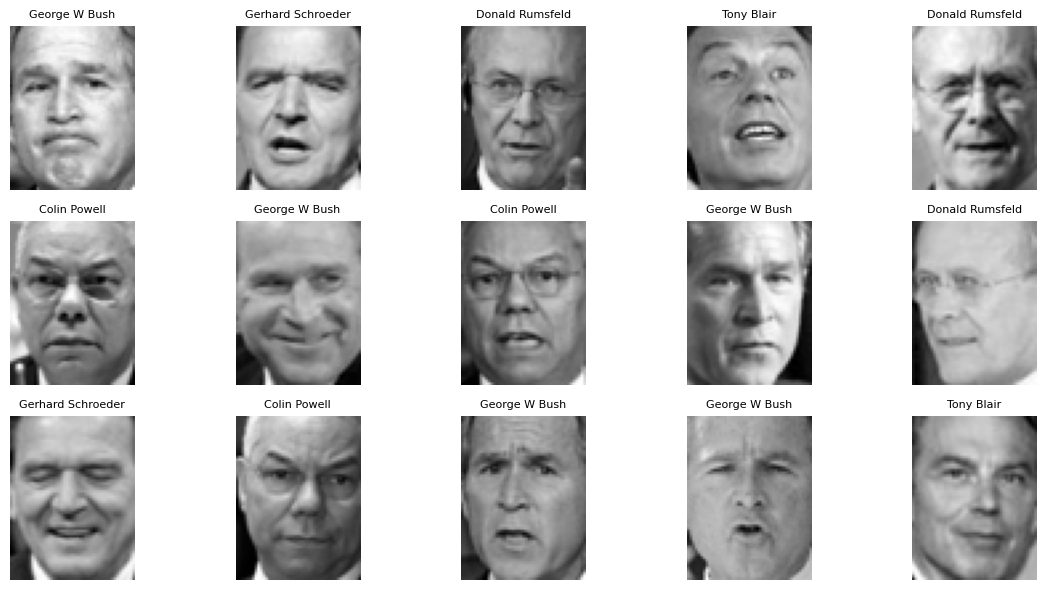

In [ ]:
# ===== CELLULE 5 : Visualisation des exemples de visages =====
# Affichage de quelques visages du dataset équilibré
print("\n=== 🔎 Visualisation de quelques visages ===")

fig, axes = plt.subplots(3, 5, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
    ax.imshow(lfw.images[i], cmap='gray')
    ax.set_title(target_names[lfw.target[i]], fontsize=8)
    ax.axis('off')
plt.tight_layout()
plt.show()

#Prétraitement des données
Dans cette section, nous appliquons deux techniques importantes de prétraitement : la normalisation des données et la réduction de dimensionnalité par PCA. La normalisation centre et réduit les données, tandis que la PCA permet de réduire la dimension des images tout en conservant l'information pertinente.


=== ⚖️ Prétraitement des données ===
Nouvelle forme des données après PCA : (1140, 100)


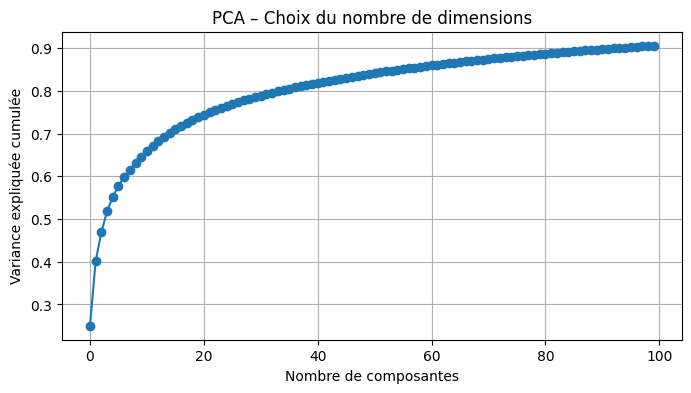

In [ ]:
# ===== CELLULE 6 : Prétraitement des données =====
print("\n=== ⚖️ Prétraitement des données ===")

# Normalisation des données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Réduction de dimension par PCA
pca = PCA(n_components=100)  # à ajuster (100 composantes principales)
X_pca = pca.fit_transform(X_scaled)

# Sauvegarder le scaler et le modèle PCA dans un fichier pkl
joblib.dump(scaler, 'pca_scaler.pkl')  # Sauvegarde du scaler
joblib.dump(pca, 'pca_model.pkl')      # Sauvegarde du modèle PCA


print(f"Nouvelle forme des données après PCA : {X_pca.shape}")

# Visualisation de la variance expliquée cumulée
plt.figure(figsize=(8, 4))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Nombre de composantes')
plt.ylabel('Variance expliquée cumulée')
plt.title('PCA – Choix du nombre de dimensions')
plt.grid(True)
plt.show()

#Visualisation des eigenfaces
Les eigenfaces sont les composantes principales obtenues après la PCA, représentées sous forme d'images. Elles montrent les caractéristiques faciales les plus distinctives qui permettent de différencier les visages.

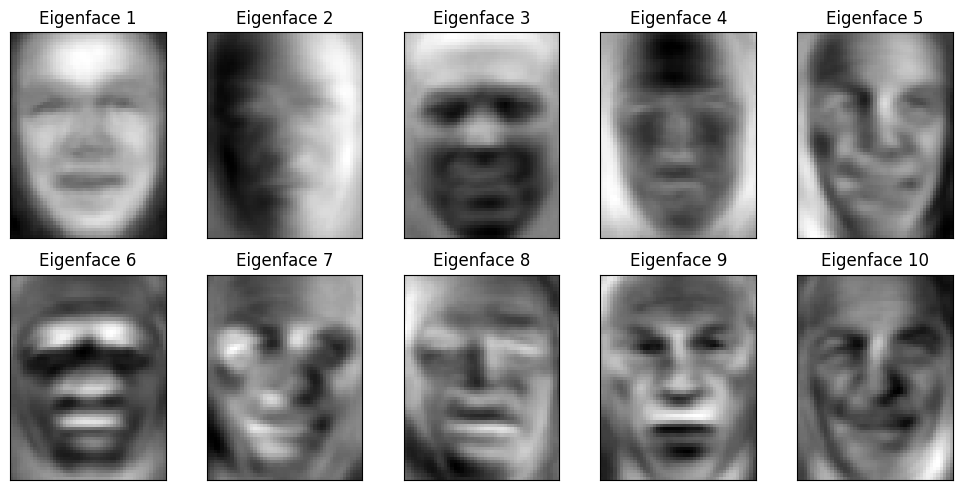

In [ ]:
# ===== CELLULE 7 : Visualisation des eigenfaces =====
# Les eigenfaces sont les vecteurs propres de la PCA, représentés sous forme d'images
eigenfaces = pca.components_.reshape((100, lfw.images.shape[1], lfw.images.shape[2]))
fig, axes = plt.subplots(2, 5, figsize=(10, 5),
                       subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    ax.imshow(eigenfaces[i], cmap='gray')
    ax.set_title(f'Eigenface {i+1}')
plt.tight_layout()
plt.show()

#Augmentation de données
L'augmentation de données est une technique cruciale pour améliorer la généralisation des modèles de deep learning. Nous créons une classe personnalisée pour appliquer diverses transformations aux images : retournements, rotations et transformations affines.

In [ ]:
# ===== CELLULE 8 : Création de la classe pour l'augmentation de données =====
print("\n=== 🔄 Augmentation de données ===")

class FaceDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        if self.transform:
            # Nécessite de reformer en image 2D pour les transformations
            h, w = int(np.sqrt(len(sample))), int(np.sqrt(len(sample)))
            sample_img = sample.reshape(1, h, w)  # Canal unique pour images en niveaux de gris
            sample_transformed = self.transform(torch.FloatTensor(sample_img))
            # Aplatir à nouveau pour le MLP
            sample = sample_transformed.reshape(-1)
        return sample, self.labels[idx]

# Définir les transformations pour l'augmentation (à utiliser si nécessaire)
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1))
])


=== 🔄 Augmentation de données ===


#Préparation des datasets et DataLoaders
Dans cette cellule, nous préparons les données pour l'entraînement en les convertissant en tenseurs PyTorch et en créant des DataLoaders. Nous effectuons également une division entre ensemble d'entraînement (80%) et ensemble de validation (20%).

In [ ]:
# ===== CELLULE 9 : Préparation des datasets et DataLoaders =====
# Conversion des données en tenseurs PyTorch
X_tensor = torch.tensor(X_pca, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

# Split train / val
dataset = TensorDataset(X_tensor, y_tensor)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_set, val_set = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = DataLoader(val_set, batch_size=64, shuffle=False)

#Visualisation des exemples augmentés
Cette cellule permet de visualiser l'effet des différentes transformations d'augmentation sur quelques images d'exemple, ce qui aide à comprendre comment l'augmentation de données diversifie notre dataset.

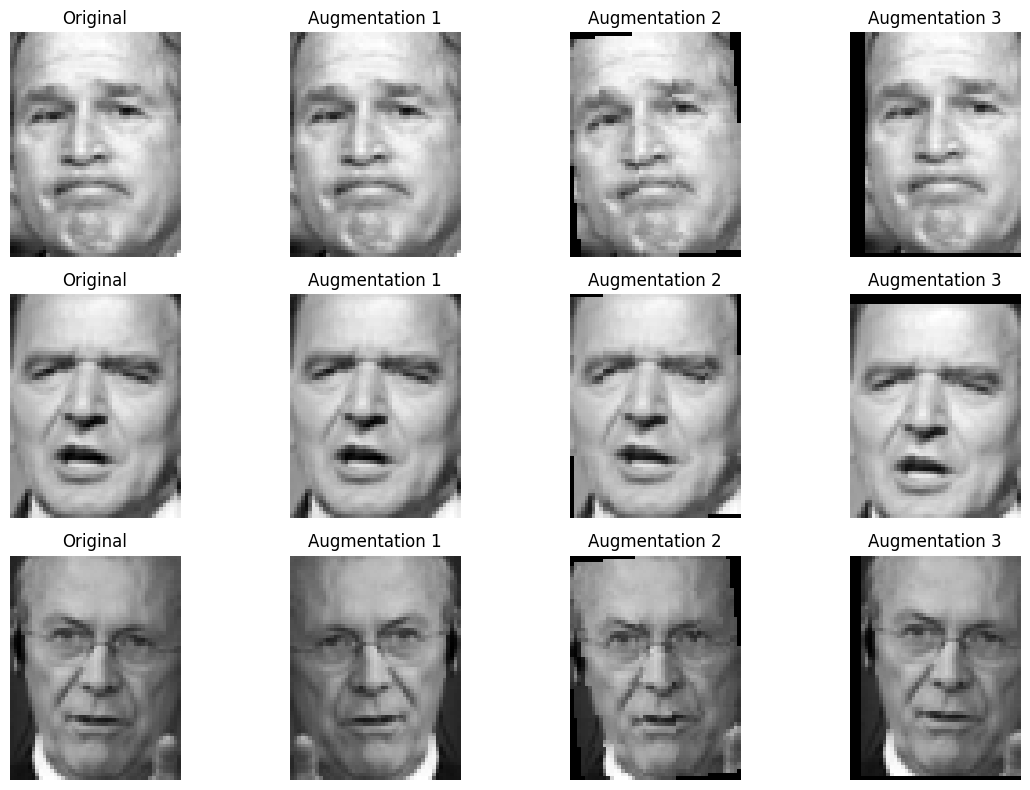

In [ ]:
# ===== CELLULE 10 : Visualisation des exemples augmentés =====
# Fonction pour visualiser les exemples d'images augmentées
def show_augmented_samples():
    # Prenons quelques exemples d'images originales
    fig, axes = plt.subplots(3, 4, figsize=(12, 8))
    for i in range(3):
        # Image originale
        img_orig = lfw.images[i]
        axes[i, 0].imshow(img_orig, cmap='gray')
        axes[i, 0].set_title(f'Original')
        axes[i, 0].axis('off')

        # Images augmentées (simulées pour visualisation)
        for j in range(1, 4):
            # Appliquer transformations manuellement pour visualiser
            img_tensor = torch.FloatTensor(img_orig).unsqueeze(0)  # Ajouter canal
            transform = transforms.Compose([
                transforms.RandomHorizontalFlip(p=0.7 if j == 1 else 0.0),
                transforms.RandomRotation(degrees=10 if j == 2 else 0),
                transforms.RandomAffine(degrees=0, translate=(0.1, 0.1) if j == 3 else (0, 0))
            ])
            img_aug = transform(img_tensor).squeeze().numpy()

            axes[i, j].imshow(img_aug, cmap='gray')
            axes[i, j].set_title(f'Augmentation {j}')
            axes[i, j].axis('off')

    plt.tight_layout()
    plt.show()

show_augmented_samples()

#Construction du modèle MLP
Cette cellule définit l'architecture de notre Perceptron Multicouche (MLP). Le modèle comprend deux couches cachées avec des activations ReLU et du dropout pour éviter le surapprentissage.

In [ ]:
# ===== CELLULE 11 : Construction du modèle MLP =====
print("\n=== 🧠 Construction du modèle MLP ===")

class MLPFaceClassifier(nn.Module):
    """
    Perceptron Multicouche (MLP) pour la classification de visages.
    Architecture : Entrée -> Hidden1 -> ReLU -> Dropout -> Hidden2 -> ReLU -> Dropout -> Sortie
    """
    def __init__(self, input_dim=100, hidden1=256, hidden2=128, dropout=0.3, n_classes=n_classes):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden1),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden1, hidden2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden2, n_classes)  # Pas de softmax ici (inclus dans CrossEntropyLoss)
        )

    def forward(self, x):
        return self.model(x)

# Instanciation
model = MLPFaceClassifier().to(device)
print(model)


=== 🧠 Construction du modèle MLP ===
MLPFaceClassifier(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=128, out_features=5, bias=True)
  )
)


#Implémentation de l'Early Stopping
L'Early Stopping est une technique de régularisation qui arrête l'entraînement lorsque les performances sur l'ensemble de validation cessent de s'améliorer. Cela permet d'éviter le surapprentissage.

In [ ]:
# ===== CELLULE 12 : Classe pour l'Early Stopping =====
print("\n=== 🏋️ Entraînement du modèle ===")

# Classe pour l'Early Stopping afin d'éviter l'overfitting
class EarlyStopping:
    """
    Arrête l'entraînement lorsque la métrique de validation cesse de s'améliorer.
    """
    def __init__(self, patience=5, delta=0.0, verbose=True):
        self.patience = patience
        self.delta = delta
        self.verbose = verbose
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.delta:
            self.counter += 1
            if self.verbose:
                print(f"⛔️ EarlyStopping : {self.counter}/{self.patience} (val_loss = {val_loss:.4f})")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0  # reset


=== 🏋️ Entraînement du modèle ===


#Fonction d'entraînement du modèle
Cette cellule définit la fonction principale d'entraînement qui gère les phases d'entraînement et de validation, le suivi des métriques et l'early stopping. La fonction retourne un historique des performances pour l'analyse ultérieure.

In [ ]:
# ===== CELLULE 13 : Fonction d'entraînement du modèle =====
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=20):
    """
    Fonction pour entraîner le modèle avec early stopping et suivi des métriques.

    Args:
        model: Le modèle à entraîner
        train_loader: DataLoader pour l'ensemble d'entraînement
        val_loader: DataLoader pour l'ensemble de validation
        criterion: Fonction de perte (loss)
        optimizer: Optimiseur
        epochs: Nombre maximum d'époques

    Returns:
        Un dictionnaire contenant l'historique des métriques
    """
    model.to(device)
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    early_stopper = EarlyStopping(patience=5, delta=0.01)

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_loss /= total
        train_acc = correct / total

        # Validation
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        val_loss /= total
        val_acc = correct / total

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | "
              f"Train Acc: {train_acc:.2%} | Val Acc: {val_acc:.2%}")

        # Early stopping check
        early_stopper(val_loss)
        if early_stopper.early_stop:
            print(f"\n⏹️ Entraînement arrêté tôt à l'époque {epoch+1} (early stopping)")
            break

    return history

#Configuration de l'entraînement
Dans cette cellule, nous définissons l'optimiseur Adam et la fonction de perte (CrossEntropyLoss), puis nous lançons l'entraînement du modèle.

In [ ]:
# Optimiseur et fonction de perte
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

# Entraînement
history = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=20)

Epoch 1/20 | Train Loss: 1.3816 | Val Loss: 1.1937 | Train Acc: 47.04% | Val Acc: 55.70%
Epoch 2/20 | Train Loss: 1.0057 | Val Loss: 0.9700 | Train Acc: 62.83% | Val Acc: 67.98%
Epoch 3/20 | Train Loss: 0.7747 | Val Loss: 0.7697 | Train Acc: 75.00% | Val Acc: 75.00%
Epoch 4/20 | Train Loss: 0.5714 | Val Loss: 0.6099 | Train Acc: 80.81% | Val Acc: 79.82%
Epoch 5/20 | Train Loss: 0.4446 | Val Loss: 0.5247 | Train Acc: 85.75% | Val Acc: 82.89%
Epoch 6/20 | Train Loss: 0.3337 | Val Loss: 0.4783 | Train Acc: 88.60% | Val Acc: 84.65%
Epoch 7/20 | Train Loss: 0.2841 | Val Loss: 0.4589 | Train Acc: 91.01% | Val Acc: 82.89%
Epoch 8/20 | Train Loss: 0.2401 | Val Loss: 0.4534 | Train Acc: 91.23% | Val Acc: 84.65%
⛔️ EarlyStopping : 1/5 (val_loss = 0.4534)
Epoch 9/20 | Train Loss: 0.2177 | Val Loss: 0.4447 | Train Acc: 91.67% | Val Acc: 85.53%
Epoch 10/20 | Train Loss: 0.1596 | Val Loss: 0.4523 | Train Acc: 95.07% | Val Acc: 85.09%
⛔️ EarlyStopping : 1/5 (val_loss = 0.4523)
Epoch 11/20 | Train Los

#Visualisation des courbes d'apprentissage
Cette cellule permet de visualiser l'évolution de la perte (loss) et de la précision (accuracy) pendant l'entraînement, à la fois sur l'ensemble d'entraînement et de validation. Ces courbes nous aident à diagnostiquer des problèmes comme le surapprentissage.

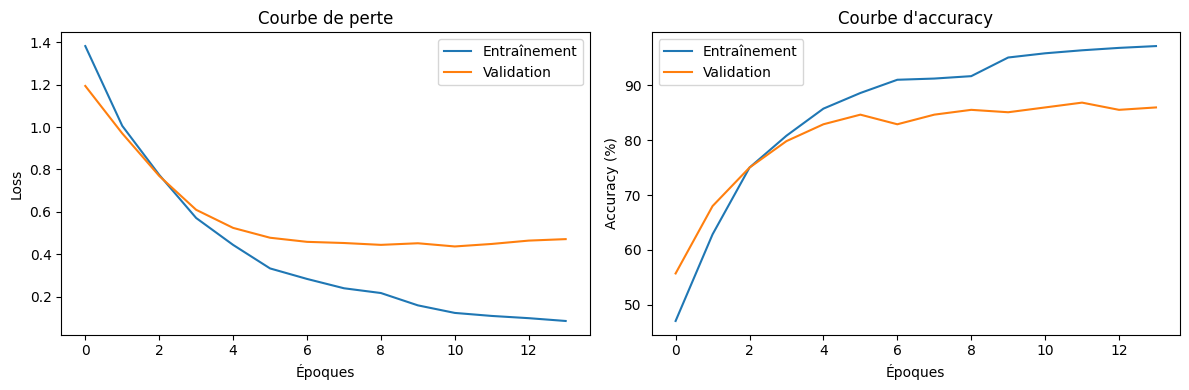

In [ ]:
# ===== CELLULE 15 : Visualisation des courbes d'apprentissage =====
# Visualisation des courbes d'apprentissage
plt.figure(figsize=(12, 4))

# Courbe de perte
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Entraînement')
plt.plot(history['val_loss'], label='Validation')
plt.xlabel('Époques')
plt.ylabel('Loss')
plt.title('Courbe de perte')
plt.legend()

# Courbe d'accuracy
plt.subplot(1, 2, 2)
plt.plot(np.array(history['train_acc']) * 100, label='Entraînement')
plt.plot(np.array(history['val_acc']) * 100, label='Validation')
plt.xlabel('Époques')
plt.ylabel('Accuracy (%)')
plt.title('Courbe d\'accuracy')
plt.legend()

plt.tight_layout()
plt.show()

#Évaluation du modèle
Dans cette section, nous évaluons les performances du modèle sur l'ensemble de validation. Nous générons un rapport de classification détaillé qui montre la précision, le rappel et le F1-score pour chaque classe.

In [ ]:
# ===== CELLULE 16 : Évaluation du modèle =====
print("\n=== 📊 Évaluation du modèle ===")

# Générer toutes les prédictions sur le set de validation
y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Rapport de classification
present_labels = sorted(set(y_true))
target_names_present = [lfw.target_names[i] for i in present_labels]

print(classification_report(y_true, y_pred, labels=present_labels, target_names=target_names_present, zero_division=0))


=== 📊 Évaluation du modèle ===
                   precision    recall  f1-score   support

     Colin Powell       0.93      0.91      0.92        47
  Donald Rumsfeld       0.88      0.72      0.79        29
    George W Bush       0.88      0.91      0.89       102
Gerhard Schroeder       0.63      0.85      0.72        20
       Tony Blair       0.88      0.73      0.80        30

         accuracy                           0.86       228
        macro avg       0.84      0.83      0.83       228
     weighted avg       0.87      0.86      0.86       228



#Matrice de confusion
La matrice de confusion est un outil visuel puissant pour évaluer les performances d'un modèle de classification. Elle montre le nombre de prédictions correctes et incorrectes pour chaque classe.

<Figure size 1000x800 with 0 Axes>

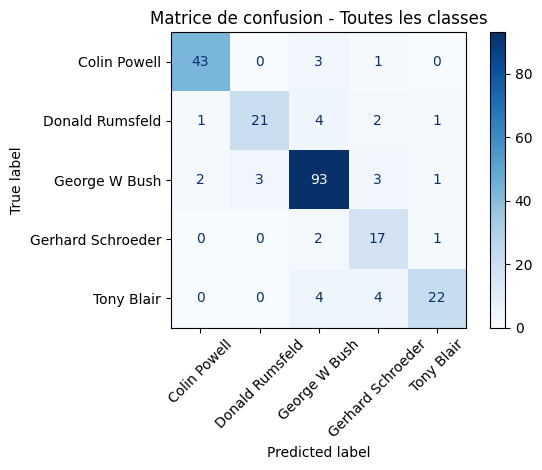

In [ ]:
# ===== CELLULE 17 : Matrice de confusion =====
# Calcul et affichage de la matrice de confusion
cm = confusion_matrix(y_true, y_pred)

# Affichage de la matrice de confusion complète
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=target_names_present)
disp.plot(xticks_rotation=45, cmap="Blues")
plt.title("Matrice de confusion - Toutes les classes")
plt.tight_layout()
plt.show()

#Optimisation des hyperparamètres avec Optuna
Optuna est une bibliothèque qui permet d'optimiser automatiquement les hyperparamètres du modèle. Dans cette cellule, nous définissons les hyperparamètres à optimiser et la fonction objectif qui sera maximisée.

In [ ]:
# ===== CELLULE 18 : Optimisation des hyperparamètres avec Optuna =====
print("\n=== 🔍 Optimisation des hyperparamètres avec Optuna ===")

def objective(trial):
    """
    Fonction objectif pour l'optimisation des hyperparamètres avec Optuna.

    Args:
        trial: Un objet trial Optuna qui suggère des valeurs pour les hyperparamètres

    Returns:
        La meilleure accuracy de validation obtenue avec les hyperparamètres suggérés
    """
    # Hyperparamètres à optimiser
    hidden1 = trial.suggest_int('hidden1', 64, 512)
    hidden2 = trial.suggest_int('hidden2', 32, 256)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)

    # Création du modèle avec les hyperparamètres suggérés
    model = MLPFaceClassifier(
        input_dim=100,
        hidden1=hidden1,
        hidden2=hidden2,
        dropout=dropout_rate,
        n_classes=n_classes
    ).to(device)

    # Optimiseur
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Entraînement et évaluation
    history = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10)

    # Retourner la meilleure accuracy de validation
    return max(history['val_acc'])

# Configuration de l'étude Optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)  # Réduire le nombre d'essais pour gagner du temps

print("Meilleurs hyperparamètres trouvés :", study.best_params)
print("Meilleure accuracy de validation :", study.best_value)

[I 2025-04-23 10:47:27,093] A new study created in memory with name: no-name-d8e39a8e-c132-4cd2-b3b4-0aa0ad5e193c



=== 🔍 Optimisation des hyperparamètres avec Optuna ===
Epoch 1/10 | Train Loss: 1.4247 | Val Loss: 1.3217 | Train Acc: 43.31% | Val Acc: 51.32%
Epoch 2/10 | Train Loss: 1.1655 | Val Loss: 1.1598 | Train Acc: 57.24% | Val Acc: 57.02%
Epoch 3/10 | Train Loss: 0.9925 | Val Loss: 1.0307 | Train Acc: 65.35% | Val Acc: 64.91%
Epoch 4/10 | Train Loss: 0.8460 | Val Loss: 0.9275 | Train Acc: 71.49% | Val Acc: 68.86%
Epoch 5/10 | Train Loss: 0.7295 | Val Loss: 0.8262 | Train Acc: 78.07% | Val Acc: 74.12%


[I 2025-04-23 10:47:27,471] Trial 0 finished with value: 0.8201754385964912 and parameters: {'hidden1': 493, 'hidden2': 130, 'dropout_rate': 0.14377500122667508, 'learning_rate': 0.00021473578764527002}. Best is trial 0 with value: 0.8201754385964912.


Epoch 6/10 | Train Loss: 0.6031 | Val Loss: 0.7483 | Train Acc: 82.46% | Val Acc: 77.63%
Epoch 7/10 | Train Loss: 0.5289 | Val Loss: 0.6825 | Train Acc: 84.65% | Val Acc: 78.51%
Epoch 8/10 | Train Loss: 0.4647 | Val Loss: 0.6427 | Train Acc: 86.40% | Val Acc: 80.70%
Epoch 9/10 | Train Loss: 0.4054 | Val Loss: 0.5977 | Train Acc: 87.83% | Val Acc: 79.39%
Epoch 10/10 | Train Loss: 0.3452 | Val Loss: 0.5616 | Train Acc: 91.23% | Val Acc: 82.02%
Epoch 1/10 | Train Loss: 1.3992 | Val Loss: 1.2801 | Train Acc: 45.07% | Val Acc: 51.32%
Epoch 2/10 | Train Loss: 1.1464 | Val Loss: 1.1211 | Train Acc: 56.36% | Val Acc: 56.58%
Epoch 3/10 | Train Loss: 0.9658 | Val Loss: 0.9894 | Train Acc: 65.02% | Val Acc: 65.79%
Epoch 4/10 | Train Loss: 0.8281 | Val Loss: 0.8584 | Train Acc: 71.38% | Val Acc: 69.74%
Epoch 5/10 | Train Loss: 0.6949 | Val Loss: 0.7468 | Train Acc: 75.77% | Val Acc: 75.00%
Epoch 6/10 | Train Loss: 0.5712 | Val Loss: 0.6524 | Train Acc: 82.79% | Val Acc: 76.75%
Epoch 7/10 | Train L

[I 2025-04-23 10:47:27,830] Trial 1 finished with value: 0.868421052631579 and parameters: {'hidden1': 177, 'hidden2': 120, 'dropout_rate': 0.13315172713112014, 'learning_rate': 0.0004819268424026335}. Best is trial 1 with value: 0.868421052631579.


Epoch 8/10 | Train Loss: 0.3883 | Val Loss: 0.5295 | Train Acc: 88.27% | Val Acc: 83.33%
Epoch 9/10 | Train Loss: 0.3276 | Val Loss: 0.4866 | Train Acc: 91.01% | Val Acc: 85.53%
Epoch 10/10 | Train Loss: 0.2794 | Val Loss: 0.4596 | Train Acc: 92.54% | Val Acc: 86.84%
Epoch 1/10 | Train Loss: 1.4332 | Val Loss: 1.2912 | Train Acc: 45.07% | Val Acc: 49.12%
Epoch 2/10 | Train Loss: 1.1996 | Val Loss: 1.1541 | Train Acc: 54.17% | Val Acc: 60.53%
Epoch 3/10 | Train Loss: 1.0330 | Val Loss: 1.0392 | Train Acc: 59.98% | Val Acc: 66.23%
Epoch 4/10 | Train Loss: 0.8970 | Val Loss: 0.9385 | Train Acc: 69.41% | Val Acc: 72.37%
Epoch 5/10 | Train Loss: 0.7929 | Val Loss: 0.8378 | Train Acc: 72.26% | Val Acc: 75.44%
Epoch 6/10 | Train Loss: 0.6690 | Val Loss: 0.7459 | Train Acc: 78.07% | Val Acc: 77.19%
Epoch 7/10 | Train Loss: 0.5850 | Val Loss: 0.6895 | Train Acc: 81.36% | Val Acc: 78.95%
Epoch 8/10 | Train Loss: 0.5032 | Val Loss: 0.6324 | Train Acc: 84.10% | Val Acc: 81.58%
Epoch 9/10 | Train L

[I 2025-04-23 10:47:28,204] Trial 2 finished with value: 0.8464912280701754 and parameters: {'hidden1': 212, 'hidden2': 216, 'dropout_rate': 0.24118574446330948, 'learning_rate': 0.00036267899573267563}. Best is trial 1 with value: 0.868421052631579.


Epoch 10/10 | Train Loss: 0.3775 | Val Loss: 0.5582 | Train Acc: 88.82% | Val Acc: 84.65%
Epoch 1/10 | Train Loss: 1.4239 | Val Loss: 1.1091 | Train Acc: 45.29% | Val Acc: 60.96%
Epoch 2/10 | Train Loss: 0.9878 | Val Loss: 0.9111 | Train Acc: 63.49% | Val Acc: 71.49%
Epoch 3/10 | Train Loss: 0.7645 | Val Loss: 0.7051 | Train Acc: 72.92% | Val Acc: 79.82%
Epoch 4/10 | Train Loss: 0.6034 | Val Loss: 0.5840 | Train Acc: 78.40% | Val Acc: 80.26%
Epoch 5/10 | Train Loss: 0.4726 | Val Loss: 0.5001 | Train Acc: 83.33% | Val Acc: 82.89%


[I 2025-04-23 10:47:28,576] Trial 3 finished with value: 0.868421052631579 and parameters: {'hidden1': 389, 'hidden2': 175, 'dropout_rate': 0.4578705344009798, 'learning_rate': 0.0012252998236967725}. Best is trial 1 with value: 0.868421052631579.


Epoch 6/10 | Train Loss: 0.3773 | Val Loss: 0.4628 | Train Acc: 86.84% | Val Acc: 84.65%
Epoch 7/10 | Train Loss: 0.3242 | Val Loss: 0.4684 | Train Acc: 88.93% | Val Acc: 84.21%
⛔️ EarlyStopping : 1/5 (val_loss = 0.4684)
Epoch 8/10 | Train Loss: 0.2452 | Val Loss: 0.4825 | Train Acc: 91.78% | Val Acc: 82.46%
⛔️ EarlyStopping : 2/5 (val_loss = 0.4825)
Epoch 9/10 | Train Loss: 0.2279 | Val Loss: 0.4636 | Train Acc: 91.23% | Val Acc: 85.09%
⛔️ EarlyStopping : 3/5 (val_loss = 0.4636)
Epoch 10/10 | Train Loss: 0.1810 | Val Loss: 0.4641 | Train Acc: 94.19% | Val Acc: 86.84%
⛔️ EarlyStopping : 4/5 (val_loss = 0.4641)
Epoch 1/10 | Train Loss: 1.4203 | Val Loss: 1.1746 | Train Acc: 44.52% | Val Acc: 56.58%
Epoch 2/10 | Train Loss: 1.0424 | Val Loss: 0.9602 | Train Acc: 61.51% | Val Acc: 67.98%
Epoch 3/10 | Train Loss: 0.7970 | Val Loss: 0.7713 | Train Acc: 70.83% | Val Acc: 74.56%
Epoch 4/10 | Train Loss: 0.6223 | Val Loss: 0.6356 | Train Acc: 79.61% | Val Acc: 79.39%
Epoch 5/10 | Train Loss: 0

[I 2025-04-23 10:47:28,947] Trial 4 finished with value: 0.868421052631579 and parameters: {'hidden1': 461, 'hidden2': 46, 'dropout_rate': 0.28425598185424383, 'learning_rate': 0.0008093793612256971}. Best is trial 1 with value: 0.868421052631579.


Epoch 8/10 | Train Loss: 0.2690 | Val Loss: 0.4577 | Train Acc: 91.67% | Val Acc: 85.09%
Epoch 9/10 | Train Loss: 0.2265 | Val Loss: 0.4339 | Train Acc: 93.20% | Val Acc: 85.96%
Epoch 10/10 | Train Loss: 0.1927 | Val Loss: 0.4135 | Train Acc: 93.97% | Val Acc: 86.84%
Epoch 1/10 | Train Loss: 1.3373 | Val Loss: 1.0878 | Train Acc: 49.56% | Val Acc: 61.84%
Epoch 2/10 | Train Loss: 0.8853 | Val Loss: 0.7654 | Train Acc: 68.42% | Val Acc: 72.37%
Epoch 3/10 | Train Loss: 0.5451 | Val Loss: 0.5415 | Train Acc: 82.68% | Val Acc: 82.02%
Epoch 4/10 | Train Loss: 0.3572 | Val Loss: 0.4653 | Train Acc: 88.71% | Val Acc: 82.89%
Epoch 5/10 | Train Loss: 0.2445 | Val Loss: 0.4474 | Train Acc: 91.67% | Val Acc: 83.77%
Epoch 6/10 | Train Loss: 0.1742 | Val Loss: 0.4609 | Train Acc: 94.30% | Val Acc: 84.21%
⛔️ EarlyStopping : 1/5 (val_loss = 0.4609)
Epoch 7/10 | Train Loss: 0.1303 | Val Loss: 0.4818 | Train Acc: 96.05% | Val Acc: 83.33%
⛔️ EarlyStopping : 2/5 (val_loss = 0.4818)
Epoch 8/10 | Train Loss

[I 2025-04-23 10:47:29,322] Trial 5 finished with value: 0.8552631578947368 and parameters: {'hidden1': 80, 'hidden2': 131, 'dropout_rate': 0.18275416480306814, 'learning_rate': 0.0023909316872349744}. Best is trial 1 with value: 0.868421052631579.


Epoch 10/10 | Train Loss: 0.0674 | Val Loss: 0.5557 | Train Acc: 98.68% | Val Acc: 85.53%
⛔️ EarlyStopping : 5/5 (val_loss = 0.5557)

⏹️ Entraînement arrêté tôt à l'époque 10 (early stopping)
Epoch 1/10 | Train Loss: 1.4162 | Val Loss: 1.2256 | Train Acc: 44.08% | Val Acc: 50.88%
Epoch 2/10 | Train Loss: 1.1127 | Val Loss: 1.0404 | Train Acc: 58.44% | Val Acc: 59.21%
Epoch 3/10 | Train Loss: 0.9471 | Val Loss: 0.8742 | Train Acc: 66.01% | Val Acc: 69.74%
Epoch 4/10 | Train Loss: 0.7784 | Val Loss: 0.7069 | Train Acc: 71.93% | Val Acc: 77.63%
Epoch 5/10 | Train Loss: 0.6106 | Val Loss: 0.6107 | Train Acc: 78.84% | Val Acc: 78.07%


[I 2025-04-23 10:47:29,680] Trial 6 finished with value: 0.8552631578947368 and parameters: {'hidden1': 311, 'hidden2': 42, 'dropout_rate': 0.42451773443992025, 'learning_rate': 0.0012053523381407273}. Best is trial 1 with value: 0.868421052631579.


Epoch 6/10 | Train Loss: 0.4877 | Val Loss: 0.5293 | Train Acc: 83.00% | Val Acc: 80.26%
Epoch 7/10 | Train Loss: 0.4318 | Val Loss: 0.4857 | Train Acc: 84.10% | Val Acc: 82.89%
Epoch 8/10 | Train Loss: 0.3526 | Val Loss: 0.4929 | Train Acc: 87.17% | Val Acc: 82.89%
⛔️ EarlyStopping : 1/5 (val_loss = 0.4929)
Epoch 9/10 | Train Loss: 0.3428 | Val Loss: 0.4529 | Train Acc: 89.14% | Val Acc: 83.77%
Epoch 10/10 | Train Loss: 0.2672 | Val Loss: 0.4483 | Train Acc: 91.12% | Val Acc: 85.53%
⛔️ EarlyStopping : 1/5 (val_loss = 0.4483)
Epoch 1/10 | Train Loss: 1.7404 | Val Loss: 1.4661 | Train Acc: 22.70% | Val Acc: 40.79%
Epoch 2/10 | Train Loss: 1.5043 | Val Loss: 1.3606 | Train Acc: 36.07% | Val Acc: 47.81%
Epoch 3/10 | Train Loss: 1.3693 | Val Loss: 1.3133 | Train Acc: 47.48% | Val Acc: 48.68%
Epoch 4/10 | Train Loss: 1.3233 | Val Loss: 1.2689 | Train Acc: 47.92% | Val Acc: 50.88%
Epoch 5/10 | Train Loss: 1.2784 | Val Loss: 1.2320 | Train Acc: 51.64% | Val Acc: 51.32%
Epoch 6/10 | Train Loss

[I 2025-04-23 10:47:30,031] Trial 7 finished with value: 0.6271929824561403 and parameters: {'hidden1': 240, 'hidden2': 117, 'dropout_rate': 0.32766203816533773, 'learning_rate': 0.00010407796844842272}. Best is trial 1 with value: 0.868421052631579.


Epoch 8/10 | Train Loss: 1.1769 | Val Loss: 1.1352 | Train Acc: 57.02% | Val Acc: 58.77%
Epoch 9/10 | Train Loss: 1.1279 | Val Loss: 1.1045 | Train Acc: 58.88% | Val Acc: 59.65%
Epoch 10/10 | Train Loss: 1.0897 | Val Loss: 1.0729 | Train Acc: 60.53% | Val Acc: 62.72%
Epoch 1/10 | Train Loss: 1.2799 | Val Loss: 0.8510 | Train Acc: 52.30% | Val Acc: 68.86%
Epoch 2/10 | Train Loss: 0.6283 | Val Loss: 0.4980 | Train Acc: 78.40% | Val Acc: 82.46%
Epoch 3/10 | Train Loss: 0.3558 | Val Loss: 0.4342 | Train Acc: 89.04% | Val Acc: 83.77%


[I 2025-04-23 10:47:30,324] Trial 8 finished with value: 0.881578947368421 and parameters: {'hidden1': 361, 'hidden2': 83, 'dropout_rate': 0.2843846513467134, 'learning_rate': 0.003300722497800758}. Best is trial 8 with value: 0.881578947368421.


Epoch 4/10 | Train Loss: 0.2111 | Val Loss: 0.4448 | Train Acc: 92.43% | Val Acc: 85.53%
⛔️ EarlyStopping : 1/5 (val_loss = 0.4448)
Epoch 5/10 | Train Loss: 0.1245 | Val Loss: 0.4900 | Train Acc: 96.16% | Val Acc: 85.09%
⛔️ EarlyStopping : 2/5 (val_loss = 0.4900)
Epoch 6/10 | Train Loss: 0.1169 | Val Loss: 0.5196 | Train Acc: 96.05% | Val Acc: 85.96%
⛔️ EarlyStopping : 3/5 (val_loss = 0.5196)
Epoch 7/10 | Train Loss: 0.0748 | Val Loss: 0.5419 | Train Acc: 97.70% | Val Acc: 86.84%
⛔️ EarlyStopping : 4/5 (val_loss = 0.5419)
Epoch 8/10 | Train Loss: 0.0466 | Val Loss: 0.5533 | Train Acc: 98.90% | Val Acc: 88.16%
⛔️ EarlyStopping : 5/5 (val_loss = 0.5533)

⏹️ Entraînement arrêté tôt à l'époque 8 (early stopping)
Epoch 1/10 | Train Loss: 1.3933 | Val Loss: 1.1909 | Train Acc: 44.96% | Val Acc: 54.82%
Epoch 2/10 | Train Loss: 0.9714 | Val Loss: 0.9582 | Train Acc: 64.04% | Val Acc: 66.23%
Epoch 3/10 | Train Loss: 0.6897 | Val Loss: 0.7100 | Train Acc: 76.21% | Val Acc: 78.07%
Epoch 4/10 | Tr

[I 2025-04-23 10:47:30,689] Trial 9 finished with value: 0.8640350877192983 and parameters: {'hidden1': 398, 'hidden2': 86, 'dropout_rate': 0.15451848029394455, 'learning_rate': 0.0007395903534071323}. Best is trial 8 with value: 0.881578947368421.


Epoch 8/10 | Train Loss: 0.1592 | Val Loss: 0.4318 | Train Acc: 96.38% | Val Acc: 85.53%
Epoch 9/10 | Train Loss: 0.1235 | Val Loss: 0.4359 | Train Acc: 97.04% | Val Acc: 85.96%
⛔️ EarlyStopping : 1/5 (val_loss = 0.4359)
Epoch 10/10 | Train Loss: 0.0993 | Val Loss: 0.4237 | Train Acc: 97.26% | Val Acc: 86.40%
⛔️ EarlyStopping : 2/5 (val_loss = 0.4237)
Meilleurs hyperparamètres trouvés : {'hidden1': 361, 'hidden2': 83, 'dropout_rate': 0.2843846513467134, 'learning_rate': 0.003300722497800758}
Meilleure accuracy de validation : 0.881578947368421


# Création du modèle final avec les meilleurs hyperparamètres

In [ ]:
# Création du modèle final avec les meilleurs hyperparamètres
best_model = MLPFaceClassifier(
    input_dim=100,
    hidden1=study.best_params['hidden1'],
    hidden2=study.best_params['hidden2'],
    dropout=study.best_params['dropout_rate'],
    n_classes=n_classes
).to(device)

# Entraînement du modèle final
best_optimizer = torch.optim.Adam(best_model.parameters(), lr=study.best_params['learning_rate'])
final_history = train_model(best_model, train_loader, val_loader, criterion, best_optimizer, epochs=20)

Epoch 1/20 | Train Loss: 1.2427 | Val Loss: 0.8304 | Train Acc: 54.06% | Val Acc: 67.98%
Epoch 2/20 | Train Loss: 0.5869 | Val Loss: 0.5209 | Train Acc: 79.39% | Val Acc: 81.58%
Epoch 3/20 | Train Loss: 0.3365 | Val Loss: 0.4590 | Train Acc: 89.04% | Val Acc: 84.65%
Epoch 4/20 | Train Loss: 0.2443 | Val Loss: 0.5090 | Train Acc: 91.01% | Val Acc: 85.53%
⛔️ EarlyStopping : 1/5 (val_loss = 0.5090)
Epoch 5/20 | Train Loss: 0.1671 | Val Loss: 0.5012 | Train Acc: 93.97% | Val Acc: 84.65%
⛔️ EarlyStopping : 2/5 (val_loss = 0.5012)
Epoch 6/20 | Train Loss: 0.1067 | Val Loss: 0.4962 | Train Acc: 96.49% | Val Acc: 86.40%
⛔️ EarlyStopping : 3/5 (val_loss = 0.4962)
Epoch 7/20 | Train Loss: 0.0897 | Val Loss: 0.5612 | Train Acc: 96.82% | Val Acc: 85.09%
⛔️ EarlyStopping : 4/5 (val_loss = 0.5612)
Epoch 8/20 | Train Loss: 0.0763 | Val Loss: 0.5360 | Train Acc: 97.04% | Val Acc: 88.60%
⛔️ EarlyStopping : 5/5 (val_loss = 0.5360)

⏹️ Entraînement arrêté tôt à l'époque 8 (early stopping)


#Évaluation finale et rapport
Cette section présente l'évaluation finale du modèle optimisé avec les meilleurs hyperparamètres trouvés. Nous générons un rapport de classification détaillé pour comprendre les performances par classe.

In [ ]:
# Évaluation finale
best_model.eval()
final_y_true = []
final_y_pred = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        outputs = best_model(inputs)
        _, predicted = torch.max(outputs, 1)
        final_y_true.extend(labels.cpu().numpy())
        final_y_pred.extend(predicted.cpu().numpy())

print("\n=== 📝 Rapport de classification final ===")
print(classification_report(final_y_true, final_y_pred, labels=present_labels, target_names=target_names_present, zero_division=0))


=== 📝 Rapport de classification final ===
                   precision    recall  f1-score   support

     Colin Powell       0.94      0.94      0.94        47
  Donald Rumsfeld       0.85      0.79      0.82        29
    George W Bush       0.87      0.92      0.90       102
Gerhard Schroeder       0.84      0.80      0.82        20
       Tony Blair       0.93      0.83      0.88        30

         accuracy                           0.89       228
        macro avg       0.89      0.86      0.87       228
     weighted avg       0.89      0.89      0.89       228



#Visualisation des courbes d'apprentissage du modèle final

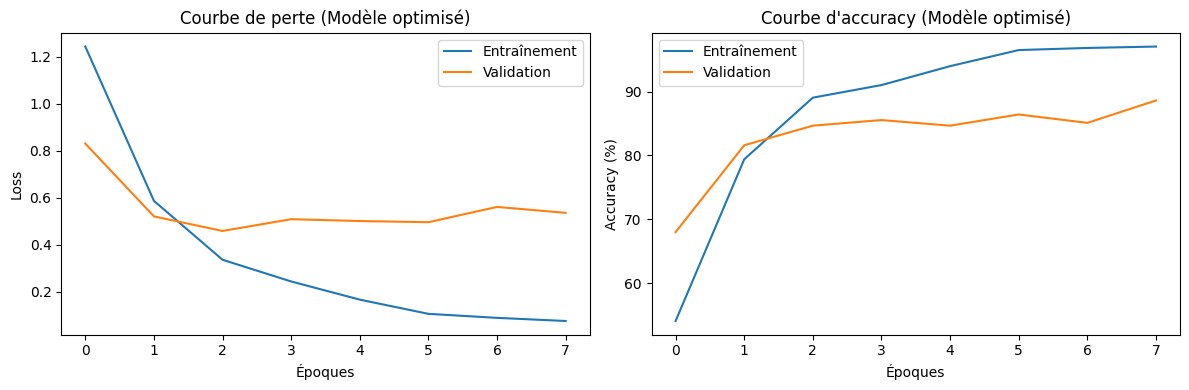

<Figure size 640x480 with 0 Axes>

In [ ]:
# Visualisation des courbes d'apprentissage du modèle final
plt.figure(figsize=(12, 4))

# Courbe de perte
plt.subplot(1, 2, 1)
plt.plot(final_history['train_loss'], label='Entraînement')
plt.plot(final_history['val_loss'], label='Validation')
plt.xlabel('Époques')
plt.ylabel('Loss')
plt.title('Courbe de perte (Modèle optimisé)')
plt.legend()

# Courbe d'accuracy
plt.subplot(1, 2, 2)
plt.plot(np.array(final_history['train_acc']) * 100, label='Entraînement')
plt.plot(np.array(final_history['val_acc']) * 100, label='Validation')
plt.xlabel('Époques')
plt.ylabel('Accuracy (%)')
plt.title('Courbe d\'accuracy (Modèle optimisé)')
plt.legend()

plt.tight_layout()
plt.show()

plt.tight_layout()
plt.show()

#Comparaison et conclusion
Cette section finale compare les performances du modèle sur différents datasets et présente les conclusions du projet. Nous discutons des avantages et limitations de notre approche.

In [ ]:
# ==================================================================
# 9. Comparaison et conclusion
# ==================================================================
print("\n=== 🔄 Comparaison des datasets et conclusion ===")

print("Résumé des performances :")
print(f"Dataset complet: {n_classes_all} classes, {X_all.shape[0]} images")
print(f"Dataset équilibré: {n_classes} classes, {X.shape[0]} images")
print(f"Accuracy sur le dataset équilibré: {max(final_history['val_acc']):.2%}")

print("""
Avantages du dataset équilibré (min_faces=80):
1. Meilleur équilibre entre les classes
2. Moins de risque de biais vers les classes sur-représentées
3. Modèle plus généralisable
4. Meilleure précision par classe individuelle
5. Entraînement plus rapide (moins de classes)

Limitations:
1. Diversité réduite (moins de personnes représentées)
2. Peut ne pas refléter la distribution réelle des visages en production

Conclusion:
L'utilisation d'un dataset équilibré avec min_faces=80 offre un compromis entre
performance et généralisation. Le modèle peut mieux apprendre les caractéristiques
distinctives de chaque personne grâce à un nombre suffisant d'exemples par classe.
"""
)


=== 🔄 Comparaison des datasets et conclusion ===
Résumé des performances :
Dataset complet: 158 classes, 4324 images
Dataset équilibré: 5 classes, 1140 images
Accuracy sur le dataset équilibré: 88.60%

Avantages du dataset équilibré (min_faces=80):
1. Meilleur équilibre entre les classes
2. Moins de risque de biais vers les classes sur-représentées
3. Modèle plus généralisable
4. Meilleure précision par classe individuelle
5. Entraînement plus rapide (moins de classes)

Limitations:
1. Diversité réduite (moins de personnes représentées)
2. Peut ne pas refléter la distribution réelle des visages en production

Conclusion:
L'utilisation d'un dataset équilibré avec min_faces=80 offre un compromis entre
performance et généralisation. Le modèle peut mieux apprendre les caractéristiques
distinctives de chaque personne grâce à un nombre suffisant d'exemples par classe.



#Visualisation des prédictions
Cette fonction nous permet de visualiser quelques exemples de prédictions du modèle, en affichant l'image originale, l'étiquette réelle et la prédiction. C'est utile pour comprendre visuellement les erreurs et succès du modèle.

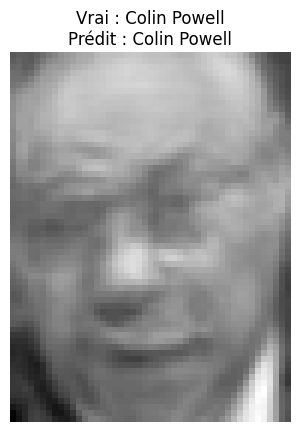

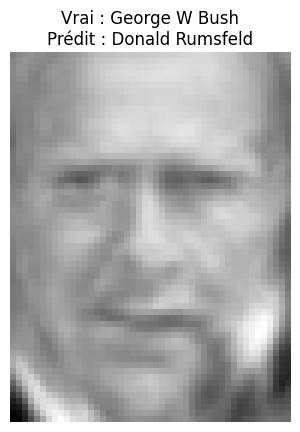

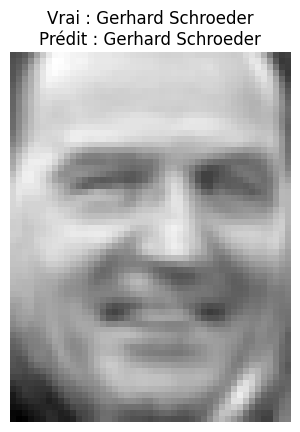

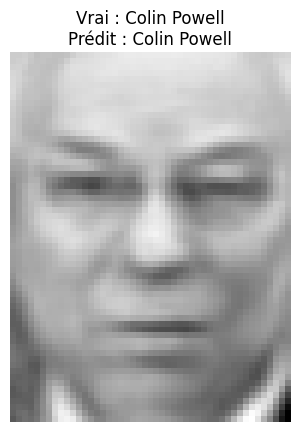

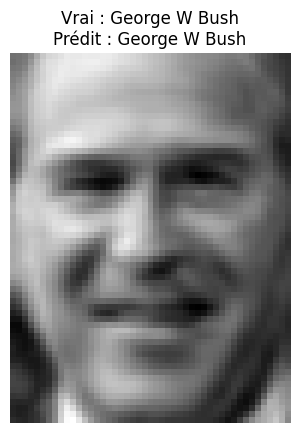


=== 🎉 Projet terminé avec succès! ===
✅ Modèle sauvegardé avec succès sous le nom 'modele_lfw.pth'


In [ ]:
1q1a\def show_predictions(model, dataloader, num_images=10):
    model.eval()
    images_shown = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for i in range(len(inputs)):
                if images_shown >= num_images:
                    return

                # Revenir à l'image originale (PCA inversé + dénormalisation)
                img_pca = inputs[i].cpu().numpy().reshape(1, -1)
                img_original = pca.inverse_transform(img_pca)
                img_original = scaler.inverse_transform(img_original)
                img_original = img_original.reshape(lfw.images.shape[1], lfw.images.shape[2])

                plt.imshow(img_original, cmap='gray')
                plt.title(f"Vrai : {target_names[labels[i]]}\nPrédit : {target_names[preds[i]]}")
                plt.axis('off')
                plt.show()

                images_shown += 1



show_predictions(model, val_loader, num_images=5)


print("\n=== 🎉 Projet terminé avec succès! ===")
torch.save(model.state_dict(), "modele_lfw.pth")
print("✅ Modèle sauvegardé avec succès sous le nom 'modele_lfw.pth'")